In [32]:
import optuna
from optuna.samplers import TPESampler
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random
import os
from joblib import dump

# Fix random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
sampler = TPESampler(seed=seed)

optuna.logging.set_verbosity(optuna.logging.WARNING)

HYPERPARAMETERS_SEARCH = False

# Pre-processing input data

In [33]:
# train_df and test_df are created in eda notebook
if not os.path.exists('csv/train_df.csv') or not os.path.exists('csv/test_df.csv'):
	print('Please run the eda notebook first')
	exit()
train_df = pd.read_csv('csv/train_df.csv')
test_df = pd.read_csv('csv/test_df.csv')
target = 'total_time_target'
features = test_df.columns.copy().drop(target).drop(['benchmark','brand_raw', 'brand_raw_target','vendor_id_raw', 'arch'])

# Spearman U Kendall correlation feature selection > 0.4
# features = ["total_time","max_ram_usage","brk","munmap","rss","vms","shared","data"]
# mean error: 2.6298196518300885 | std error: 6.704351557190401

# Split data
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Normalize data
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

In [34]:
if not os.path.exists('../models/x_scaler.joblib') or not os.path.exists('../models/y_scaler.joblib'):
	dump(x_scaler, '../models/x_scaler.joblib')
	dump(y_scaler, '../models/y_scaler.joblib')

# Model: XGBoost

In [35]:
def inv_scaling(y, y_scaler):
    return y_scaler.inverse_transform(y.reshape(-1, 1))

# Hyperparameters Optimization

In [36]:
def objective(trial: optuna.Trial, X_train, y_train, X_test, y_test):
	dtrain = xgb.DMatrix(X_train, label=y_train)
	dtest = xgb.DMatrix(X_test, label=y_test)
	
	# Definimos los hiperparámetros a buscar (XGBoost)
	param = {
		"verbosity": 0,
		"device": "cuda",
		"objective": "reg:squarederror",
		"eval_metric": "rmse",
		"booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
		# L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
		"learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
	}
	num_boost_round = trial.suggest_int("num_boost_round", 10, 1000, step=10)
    
	if param["booster"] in ["gbtree", "dart"]:
		# maximum depth of the tree, signifies complexity of the tree.
		param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
		# minimum child weight, larger the term more conservative the tree.
		param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
		param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
		# defines how selective algorithm is.
		param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
		param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

	if param["booster"] == "dart":
		param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
		param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
		param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
		param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

	# training
	evals_result = {}
	xgb.train(
		param, 
		dtrain,
		num_boost_round=num_boost_round,
		evals=[(dtrain, "train"), (dtest, "test")],
		evals_result=evals_result,
		verbose_eval=False,
		early_stopping_rounds=25
	)
	loss = evals_result['train']['rmse'][-1]
	val_loss = evals_result['test']['rmse'][-1]
	print(f"Trial: {trial.number} - RMSE Loss : {loss} - RMSE Val Loss: {val_loss}")
	return val_loss

n_trials = 100
study = None

In [37]:
if HYPERPARAMETERS_SEARCH:
	study = optuna.create_study(direction='minimize', sampler=sampler)
	study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=n_trials)

In [38]:
if study is not None:
	print(f'Number of trials: {len(study.trials)}')
	trial = study.best_trial
	print(f'Best trial: {trial.number}')
	print(f'Best params: {trial.params}')
	print(f'Best validation loss: {y_scaler.inverse_transform(np.reshape(trial.value, (-1,1))).item()}')

# Training

In [39]:
# hyperparameters
params = {
	"device": "cuda",
	"objective": "reg:squarederror",
	"eval_metric": "rmse",
}
if study is not None:
	num_boost_round = study.best_trial.params['num_boost_round']
	params.update(*study.best_trial.params)
	params.pop('num_boost_round')
else:
	num_boost_round = 10

In [40]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

evals_result = {}
model = xgb.train(
	params, 
	dtrain,
	num_boost_round=num_boost_round,
	evals=[(dtrain, "train"), (dtest, "test")],
	evals_result=evals_result,
	early_stopping_rounds=5
)

[0]	train-rmse:0.03772	test-rmse:0.03486
[1]	train-rmse:0.02675	test-rmse:0.02437
[2]	train-rmse:0.01911	test-rmse:0.01760
[3]	train-rmse:0.01378	test-rmse:0.01302
[4]	train-rmse:0.01004	test-rmse:0.00999
[5]	train-rmse:0.00747	test-rmse:0.00811
[6]	train-rmse:0.00572	test-rmse:0.00693
[7]	train-rmse:0.00456	test-rmse:0.00624
[8]	train-rmse:0.00383	test-rmse:0.00570
[9]	train-rmse:0.00331	test-rmse:0.00544


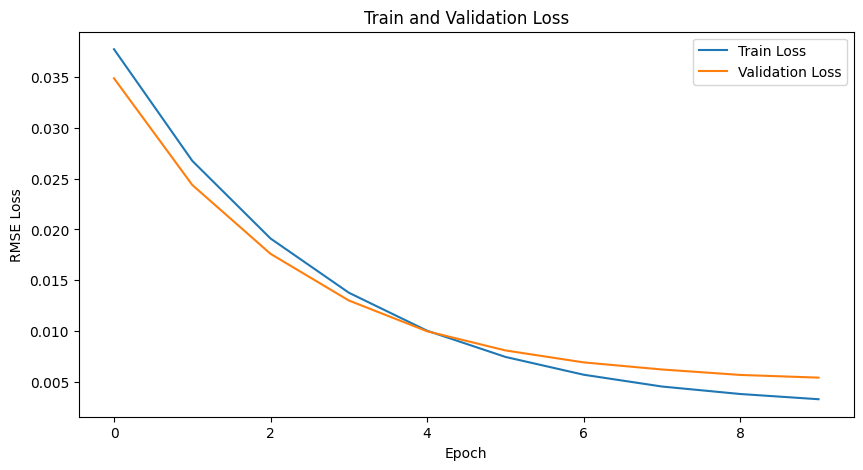

In [41]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(evals_result['train']['rmse'], label='Train Loss')
plt.plot(evals_result['test']['rmse'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')
plt.legend()
plt.show()

In [42]:
# save model
model.save_model(f'../models/xgboost_model.json')

# Describe Validation

In [43]:
model = xgb.Booster()
model.load_model('../models/xgboost_model.json')

In [44]:
def describe_val(model, X, y, y_scaler):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}
	dtest = xgb.DMatrix(X)
	predictions = model.predict(dtest)
	predictions = inv_scaling(predictions, y_scaler)
	y_scaled = inv_scaling(y, y_scaler)
	index_min = np.argmin(np.abs(predictions - y_scaled))
	min_instance["prediction"] = predictions[index_min].item()
	min_instance["actual"] = y_scaled[index_min].item()
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y_scaled))
	max_instance["prediction"] = predictions[index_max].item()
	max_instance["actual"] = y_scaled[index_max].item()
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions

In [45]:
test_df_og = pd.read_csv('csv/test_df.csv')

In [46]:
print("Validation set single thread model")
min_instance, max_instance, predictions = describe_val(model, X_test, y_test, y_scaler)
y_scaled = inv_scaling(y_test, y_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model
Mean prediction: 23.341108322143555 | Std actual: 42.97887420654297
Mean actual: 23.401548499932737 | Std actual: 44.0307253488359
Mean Error: 1.673530272956365 | Std Error: 4.586831653361785
Min instance
total_time                                                             9.82
total_cpu_usage                                                        0.99
max_ram_usage                                                    341.507812
brand_raw                          Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    12
l2_cache_size                                                           1.5
l3_cache_size                                                          12.0
l2_cache_line_size                                                      256


In [47]:
# get index of total_time_target < 2.00
index = test_df_og[test_df_og['total_time_target'] < 2.0].index
X_test_low = X_test[index]
y_test_low = y_test[index]
test_df_og_low = test_df_og.iloc[index].reset_index(drop=True)
min_instance, max_instance, predictions = describe_val(model, X_test_low, y_test_low, y_scaler)
y_scaled = inv_scaling(y_test_low, y_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Validation set single thread model with total_time_target > 150.0")
print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og_low.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og_low.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model with total_time_target > 150.0
Mean prediction: 1.3696435689926147 | Std actual: 0.5166702270507812
Mean actual: 0.7286966731898239 | Std actual: 0.5568325855632882
Mean Error: 0.6414064554225676 | Std Error: 0.18903647959791875
Min instance
total_time                                                             1.05
total_cpu_usage                                                        0.99
max_ram_usage                                                     13.242188
brand_raw                          Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    12
l2_cache_size                                                           1.5
l3_cache_size                                                          12.0
l2_cache_line_size                     

In [48]:
# get index of 2.00 > total_time_target > 150.0
index = test_df_og[(test_df_og['total_time_target'] <= 150.0) & (test_df_og['total_time_target'] >= 2.0)].index
X_test_med = X_test[index]
y_test_med = y_test[index]
test_df_og_med = test_df_og.iloc[index].reset_index(drop=True)
min_instance, max_instance, predictions = describe_val(model, X_test_med, y_test_med, y_scaler)
y_scaled = inv_scaling(y_test_med, y_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Validation set single thread model with total_time_target in [2.0, 150.0]")
print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og_med.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og_med.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model with total_time_target in [2.0, 150.0]
Mean prediction: 26.312360763549805 | Std actual: 22.51384162902832
Mean actual: 26.370051096444538 | Std actual: 22.30011708610565
Mean Error: 1.6681434454581876 | Std Error: 1.6318709233866224
Min instance
total_time                                                             9.82
total_cpu_usage                                                        0.99
max_ram_usage                                                    341.507812
brand_raw                          Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    12
l2_cache_size                                                           1.5
l3_cache_size                                                          12.0
l2_cache_line_size                

In [49]:
# get index of total_time_target > 150.0
index = test_df_og[test_df_og['total_time_target'] > 150.0].index
X_test_high = X_test[index]
y_test_high = y_test[index]
test_df_og_high = test_df_og.iloc[index].reset_index(drop=True)
min_instance, max_instance, predictions = describe_val(model, X_test_high, y_test_high, y_scaler)
y_scaled = inv_scaling(y_test_high, y_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print("Validation set single thread model with total_time_target < 2.00")
print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(test_df_og_high.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(test_df_og_high.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model with total_time_target < 2.00
Mean prediction: 256.38592529296875 | Std actual: 36.69209289550781
Mean actual: 266.41856353591163 | Std actual: 12.794637910567754
Mean Error: 16.38280255228117 | Std Error: 23.72728005122391
Min instance
total_time                                                           278.55
total_cpu_usage                                                        0.99
max_ram_usage                                                          74.5
brand_raw                          Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz
vendor_id_raw                                                  GenuineIntel
arch                                                                 X86_64
count                                                                    12
l2_cache_size                                                           1.5
l3_cache_size                                                          12.0
l2_cache_line_size                          

# SHAP Analysis

In [50]:
test_df_og = test_df_og.iloc[::30]
y_prediction = inv_scaling(model.predict(xgb.DMatrix(X_test[::30])), y_scaler)
test_df_og.shape

(248, 43)

In [51]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(xgb.DMatrix(X_test[::30]))
X_test_non_scaled = x_scaler.inverse_transform(X_test[::30])
shap.initjs()

In [52]:
shap.force_plot(explainer.expected_value, shap_values, X_test_non_scaled, feature_names=features)

Prediction: 289.5544738769531 | Actual: 269.24


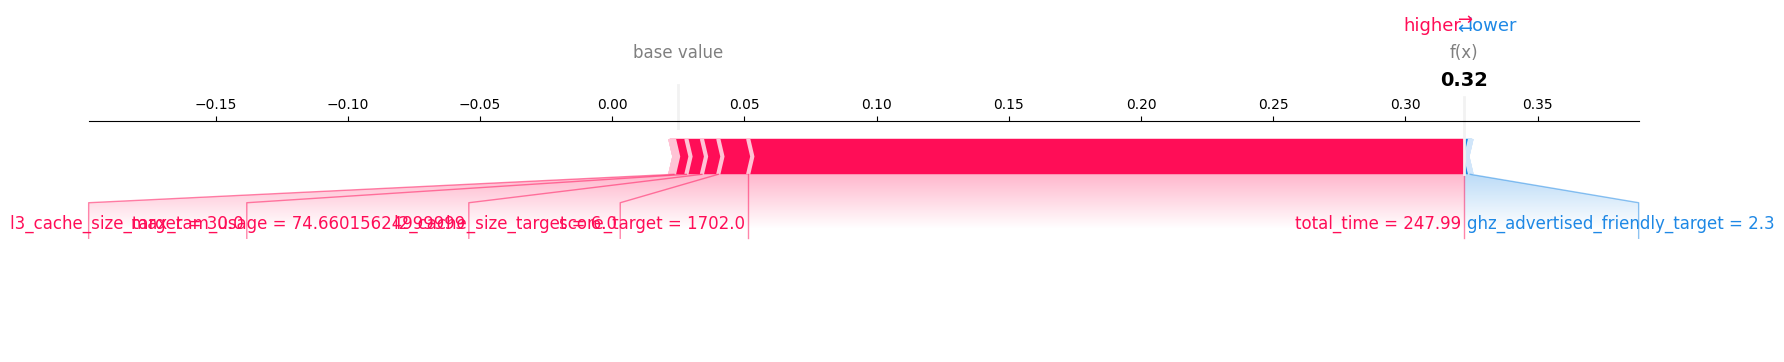

In [53]:
instance = 1
print(f"Prediction: {y_prediction[instance].item()} | Actual: {test_df_og.iloc[instance]['total_time_target']}")
shap.force_plot(explainer.expected_value, shap_values[instance], X_test_non_scaled[instance], feature_names=features, matplotlib=True)

Prediction: 2.277805805206299 | Actual: 1.95


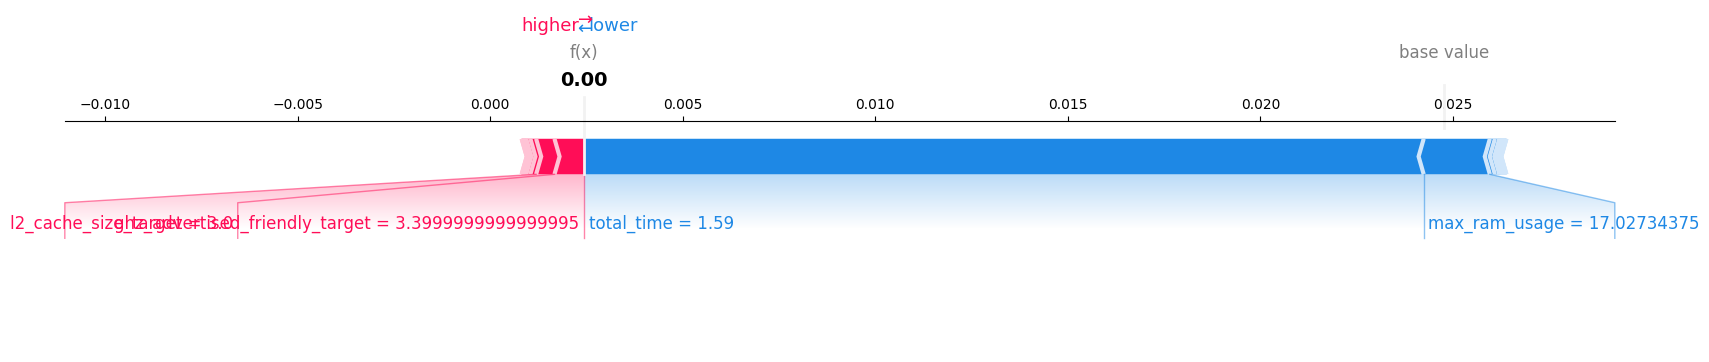

In [54]:
instance =163
print(f"Prediction: {y_prediction[instance].item()} | Actual: {test_df_og.iloc[instance]['total_time_target']}")
shap.force_plot(explainer.expected_value, shap_values[instance], X_test_non_scaled[instance], feature_names=features, matplotlib=True)

Prediction: 37.014957427978516 | Actual: 35.4


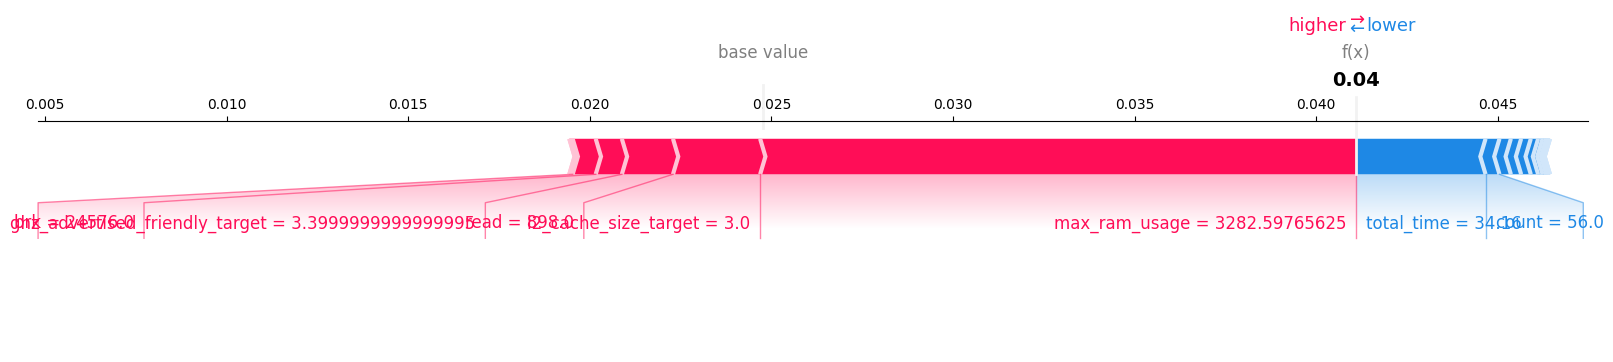

In [55]:
instance = 77
print(f"Prediction: {y_prediction[instance].item()} | Actual: {test_df_og.iloc[instance]['total_time_target']}")
shap.force_plot(explainer.expected_value, shap_values[instance], X_test_non_scaled[instance], feature_names=features, matplotlib=True)

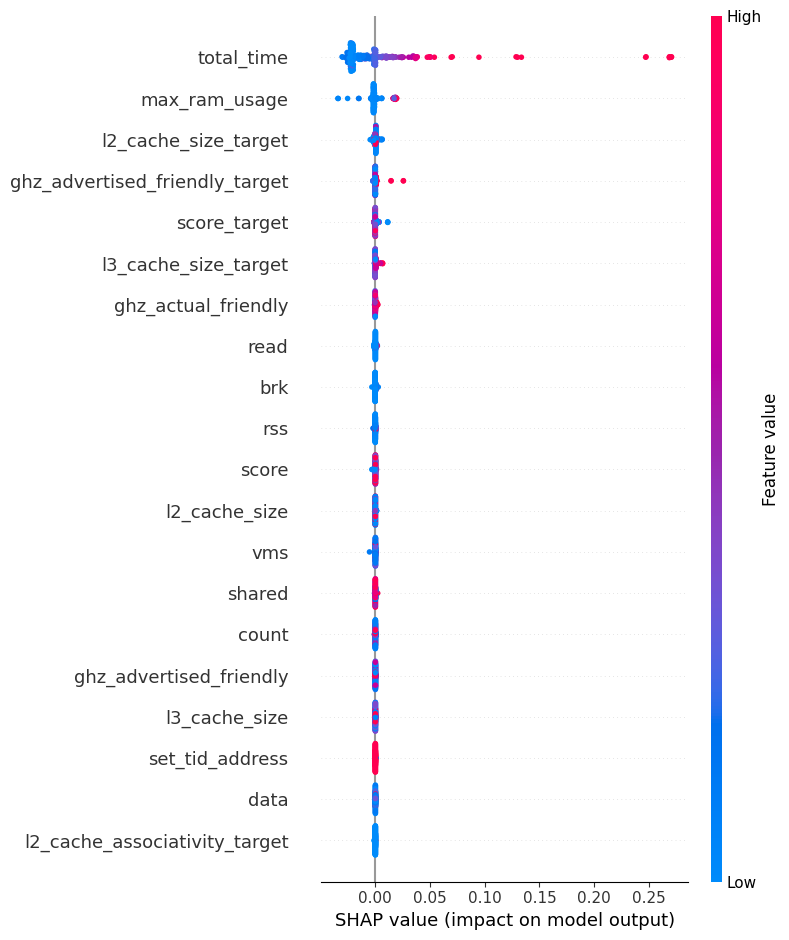

In [56]:
# Sumarize the effects of all the features
shap.summary_plot(shap_values, X_test_non_scaled, feature_names=features)

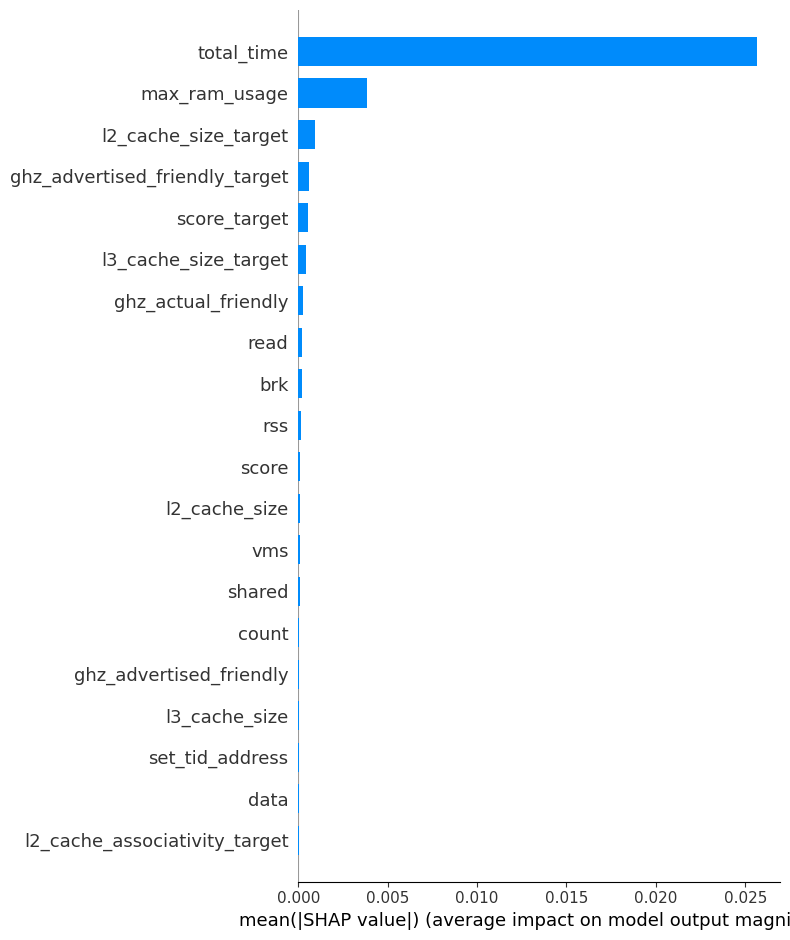

In [57]:
shap.summary_plot(shap_values, X_test_non_scaled, feature_names=features, plot_type='bar')

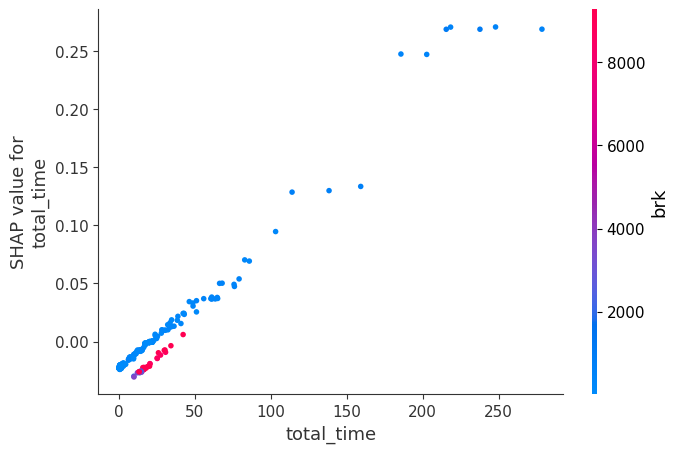

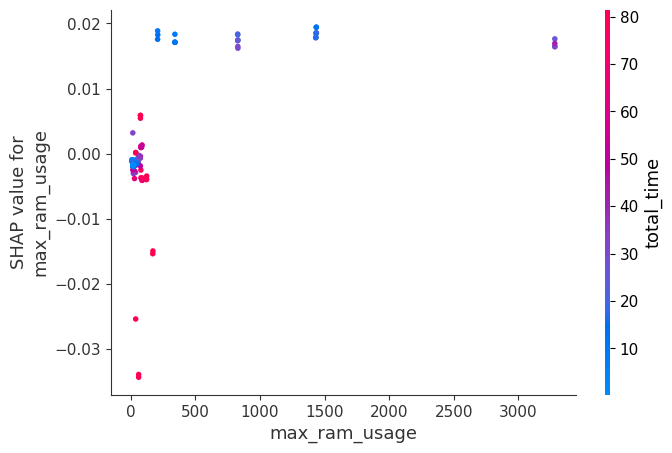

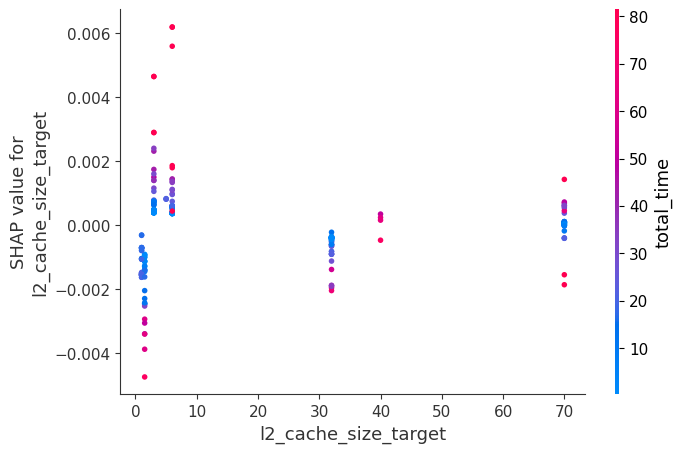

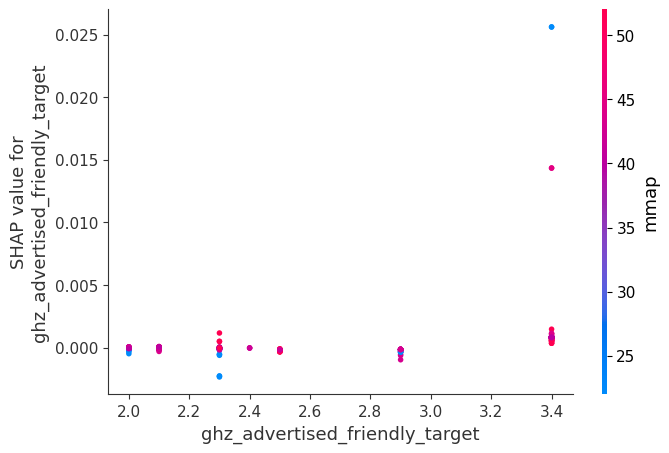

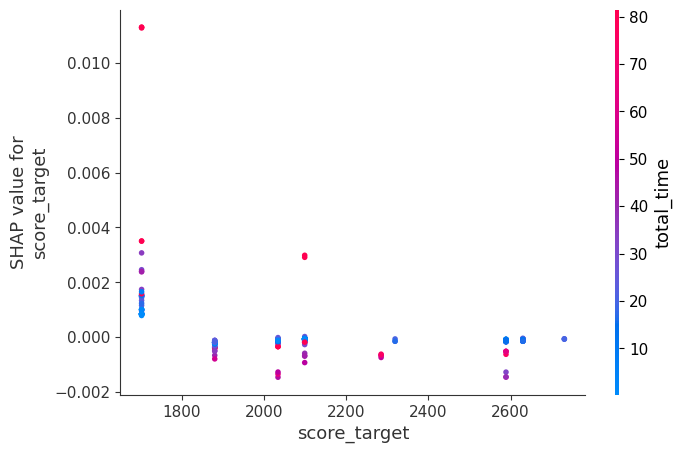

In [58]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the test set)
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))
for i in range(5):
    # shap.common.approximate_interactions is used to pick what seems to be the strongest interaction 
    shap.dependence_plot(top_inds[i], shap_values, X_test_non_scaled, feature_names=features)